In [1]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

(-0.5, 255.5, 255.5, -0.5)

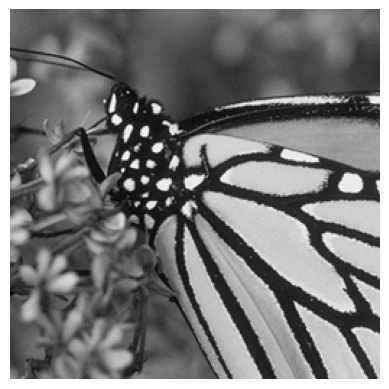

In [2]:
case = 5
i = 9
r0 = 100
r1 = 40
sigma1 = 5
sigma2 = 50
D0 = 15
n = 5
img = imageio.imread(f'Dataset/in/0{case}.png')
plt.imshow(img, cmap="gray")
plt.axis('off')

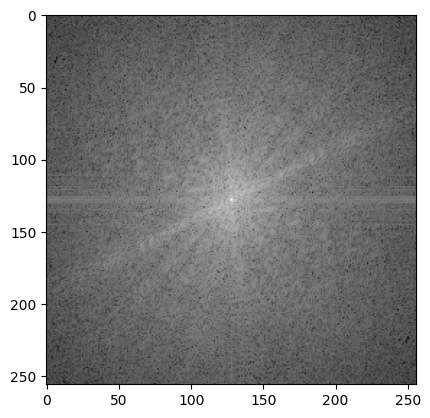

In [3]:
def get_fft(img):
    return np.fft.fftshift(np.fft.fft2(img))

F = get_fft(img)
plt.imshow(np.log(1+np.abs(F)), cmap="gray")

In [4]:
P, Q = F.shape
print(f'P: {P}')
print(f'Q: {Q}')

P: 256
Q: 256


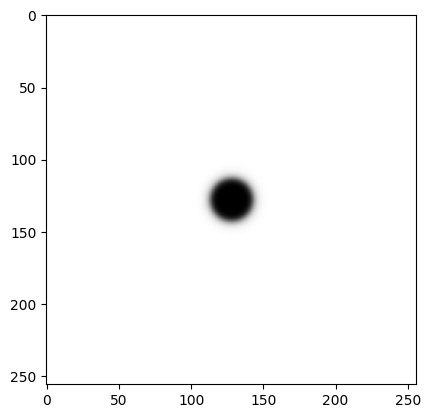

In [5]:
def distance(p0, p1):
    if isinstance(p0, (int, float, complex)) and isinstance(p1, (int, float, complex)):
        distance = np.abs(p0 - p1)
        #print(f'p0: {p0}\tp1: {p1}\distance: {distance}')
    elif isinstance(p0, tuple) and isinstance(p1, tuple):
        distance = np.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)
    else:
        raise ValueError('Points p0 and p1 must be of a number of tuple type')
    return distance

def low_pass(u, v, P, Q, r):
    if distance((u, v), (P/2, Q/2)) <= r:
        return 1
    else:
        return 0

def high_pass(u, v, P, Q, r):
    if distance((u, v), (P/2, Q/2)) <= r:
        return 0
    else:
        return 1
    
def band_pass(u, v, P, Q, r0, r1):
    return low_pass(u, v, P, Q, r0) - low_pass(u, v, P, Q, r1)

def band_reject(u, v, P, Q, r0, r1):
    return high_pass(u, v, P, Q, r0) - high_pass(u, v, P, Q, r1)

def laplacian_low_pass(u, v, P, Q):
    return -4*np.pi**2 * (distance((u, v), (P/2, Q/2))**2)

def laplacian_high_pass(u, v, P, Q):
    return 4*np.pi**2 * (distance((u, v), (P/2, Q/2))**2)
        
def gaussian_low_pass(u, v, P, Q, sigma1, sigma2):
    squared_distance_row = distance(u, P/2)**2
    squared_distance_col = distance(v, Q/2)**2
    row = squared_distance_row / (2*sigma1**2)
    col = squared_distance_col / (2*sigma2**2)
    x = row + col
    return np.exp(-1*x)

def gaussian_high_pass(u, v, P, Q, sigma1, sigma2):
    return 1 - gaussian_low_pass(u, v, P, Q, sigma1, sigma2)

def butterworth_low_pass(u, v, P, Q, D0, n):
    distance_center = distance((u, v), (P/2, Q/2))
    return 1 / (1 + (distance_center/D0)**(2*n))

def butterworth_high_pass(u, v, P, Q, D0, n):
    return 1 - butterworth_low_pass(u, v, P, Q, D0, n)
    
def get_filter(shape, filter_func, *args):
    filter = np.zeros(shape, dtype=np.float32)
    
    for u in range(P):
        for v in range(Q):
            filter[u, v] = filter_func(u, v, P, Q, *args)
            
    return filter

match i:
    case 0:
        filter = get_filter((P, Q), low_pass, r0)
    case 1:
        filter = get_filter((P, Q), high_pass, r0)
    case 2:
        filter = get_filter((P, Q), band_pass, r0, r1)
    case 3:
        filter = get_filter((P, Q), band_reject, r0, r1)
    case 4:
        filter = get_filter((P, Q), laplacian_high_pass)
    case 5:
        filter = get_filter((P, Q), laplacian_low_pass)
    case 6:
        filter = get_filter((P, Q), gaussian_low_pass, sigma1, sigma2)
    case 7:
        filter = get_filter((P, Q), gaussian_high_pass, sigma1, sigma2)
    case 8:
        filter = get_filter((P, Q), butterworth_low_pass, D0, n)
    case 9:
        filter = get_filter((P, Q), butterworth_high_pass, D0, n)
        
plt.imshow(filter, cmap="gray")

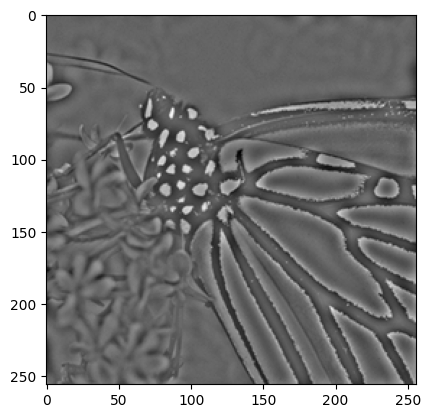

In [6]:
#img_filtered = np.clip(img_filtered.real, 0, 255)

def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

def apply_filter(F, filter):
    F_filtered = np.multiply(F, filter)
    img_filtered = np.fft.ifft2(np.fft.ifftshift(F_filtered)).real
    img_filtered = normalize(img_filtered) * 255
    return img_filtered

img_filtered = apply_filter(F, filter)
plt.imshow(img_filtered, cmap="gray")

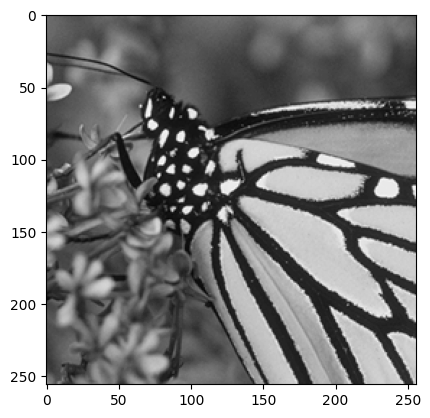

In [7]:
expected = imageio.imread(f'Dataset/gt/0{case}.png')
plt.imshow(expected, cmap="gray")

In [8]:
def root_mean_squared_error(reference_img, enhanced_img):
  """
  Computes then returns the Root Mean Squared Error (RMSE) between the reference image and the enhanced image.
  """
  M, N = reference_img.shape

  sum = 0
  for i in range(M):
    for j in range(N):
      sum += (reference_img[i][j] - enhanced_img[i][j])**2

  error = np.sqrt(sum/(M*N))

  return error

In [9]:
root_mean_squared_error(expected, img_filtered)

44.267234397617315